In [1]:
#Training, and then evaluation of model on train_2.csv dataset

#NOTE: Warning generated for using TensorFlow 1.4 with Python3.6 should be ignored.
#/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205:
# RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util'
#does not match runtime version 3.6  return f(*args, **kwds)

from __future__ import print_function, division
import os
import os.path
import numpy as np
import sys, getopt
import math
import csv
import pickle
import datetime
import time
import tensorflow as tf
from tensorflow.contrib import rnn

import matplotlib.pyplot as plt
from matplotlib import gridspec

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
############ Parameters to control run #############
#Use CPU only or Nvidia GPU
use_cpu_only = False

#Use a fixed initial seed
deterministic_init = True

#Batch size
BS = 1

#Number of timesteps to look backwards - Back prop length
BL = 20

#Number of steps to look ahead
#FL = 64


#LSTM statesize
stateSize = 20

#Number of Epochs to Iterate over
num_epochs = 10

#Sequence Length
M = 803

#Validation set size - 64 days
#(i.e., from 7/9/2017 to 9/10/2017 prediction)
V = 64

#Learning rate, decay factor
lrate_initial = 2.0
lrate_end = 2.0
ldecay_rate = (lrate_initial - lrate_end)/num_epochs

#Turn on/off animated display with learning
display_on = True

if use_cpu_only:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

if deterministic_init:   
    tf.set_random_seed(1)


In [3]:
############ Load up saved data  #############
#Load up X (23 features) and Y (expected ouput data)
X = np.load("Data/Xdata.npy")
Y = np.load("Data/Ydata.npy")

with open("Data/index2Site.pkl", 'rb') as f:
    index2Site = pickle.load(f)
with open("Data/column2Date.pkl", 'rb') as f:
    column2Date = pickle.load(f)
print("Completed loading X, Y and key data ", X.shape, Y.shape)

(nSites, nDates, nFeatures) = X.shape

#Expect to train multiple sites at a time
tstId = range(nSites)

siteName = []

for i in tstId:
    siteName.append(index2Site[i])

Completed loading X, Y and key data  (145063, 803, 23) (145063, 803)


In [4]:
#Create the LSTM network
X_placeholder = tf.placeholder(tf.float64, [BS,BL*nFeatures]) 
Y_placeholder = tf.placeholder(tf.float64)
lrate_placeholder = tf.placeholder(tf.float32, shape=[])

cell_state = tf.placeholder(tf.float64, [BS, stateSize])
hidden_state = tf.placeholder(tf.float64, [BS, stateSize])
init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state)

lstm = rnn.BasicLSTMCell(stateSize, state_is_tuple=True)

output = []
state = init_state
for i in range(BL):
    output, state = lstm(X_placeholder[0:BS,i*nFeatures:(i+1)*nFeatures], state)
final_state = output

num_classes = 1
W = tf.Variable(np.ones((stateSize, num_classes),dtype=np.float64))
b = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float64)
Ypred = [tf.matmul(final_state, W) + b]

#Mean squared error between predicted and actual sequence
loss = tf.reduce_sum(tf.pow(Ypred - Y_placeholder, 2.0))

# Call optimizer
learning_rate = lrate_initial
optimizer = tf.train.AdagradOptimizer(learning_rate=lrate_placeholder).minimize(loss)

In [5]:
#Plotting Utilities
def gplot2(loss_list, Yactual, Ypred, epoch, M, V):
    gs = gridspec.GridSpec(10, 1)
    segs = 20
    enable_loss = True
    if(enable_loss):
        Xaxis = range(BL, len(loss_list)+BL, 1)
        plt.ylabel("Loss Value")
        plt.plot(Xaxis, loss_list, label="Loss")
        plt.xticks(np.array(range(0,M+segs,M//segs)))

    #plt.subplot(2, 1, 2)
    plt.subplot(gs[1:,:])
    plt.cla()
    plt.title("Prediction for %s" % (siteName[69113]))

    Xaxis = range(BL, len(Yactual)+BL, 1)

    actual = plt.plot(Xaxis, Yactual, label="Y")
    plt.xlabel("Timestep")
    plt.xticks(np.array(range(0,M+segs,M//segs)))
    
    if V == -1:
        #Graphing of training stage
        train, = plt.plot(Xaxis, Ypred, label="Ytrain")
        plt.ylabel("Y: Actual vs Train")
        plt.legend([actual, train], ["Y", "Ytrain"])
        plt.xticks(np.array(range(0,M+segs,M//segs)))

    else:
        #Graphing of evaluation stage
        test, = plt.plot(Xaxis[-V:-2], Ypred[-V:-2], label="Ytest")
        plt.xticks(np.array(range(0,M+segs,M//segs)))
        plt.ylabel("Y: Actual vs Predicted")
    plt.draw()
    plt.pause(0.00001)

In [6]:
#Log all results in a file with datename
filename = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
fp = open(filename, 'a')
run_start = str(datetime.datetime.now())
start_time = time.time()

Processing Batch  range(69113, 69114)


Training ...
Train time per Epoch = 4.399e+00 secs
..........Training Done
Evaluation on test data
Evaluation time = 2.015e-01 secs


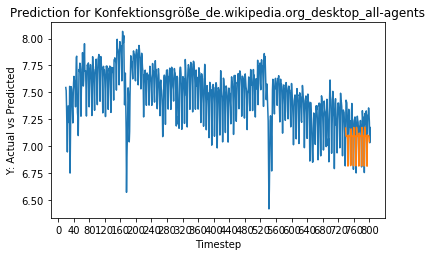

In [7]:
#Demo with specific timeseries
startId = 69113
endId = 69114
BS = 1

fp.write("#Run started at %s\n" % run_start)
fp.write("#BS = %d BL = %s Statesize=%d TS_start=%d TS_end=%d\n" % (BS, BL, stateSize, startId, endId))

#Main Train/Predict Loop
for i in range(startId, endId, BS):
    tstId = range(i,i+BS,1)
    print("Processing Batch ", tstId)
    fp.write("#Processing Batch \n"+str(tstId))

    _current_cell_state = np.zeros((BS,stateSize),dtype=np.float64)
    _current_hidden_state = np.zeros((BS,stateSize),dtype=np.float64)
    _current_state = _current_cell_state, _current_hidden_state
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        if display_on:
            plt.ion()
            plt.figure(figsize=(10, 6))
            plt.show()
            
        loss_list = []
    
        print("Training ...")

        learning_rate = lrate_initial
        for e in range(num_epochs):

            F1 = Y[tstId,BL:(M-V)]
            F2 = []
            loss_list = []
            t1 = time.time()
            for i in range(M-V-BL):
                Lstm_in = np.zeros((BS,BL*nFeatures))
                for k in tstId:
                    Lstm_in[k-tstId[0]] = X[k,i:(i+BL)].flatten()
                Lstm_out = Y[tstId,i+BL]
    
                _loss, _optimizer, _final_state, _current_state, _output, _Ypred = sess.run(
                    fetches=[loss, optimizer, final_state, state, output, Ypred],
                    feed_dict={
                        X_placeholder: Lstm_in,
                        Y_placeholder: Lstm_out,
                        cell_state: _current_cell_state,
                        hidden_state: _current_hidden_state,
                        lrate_placeholder: learning_rate
                    })
                _current_cell_state, _current_hidden_state = _current_state
                loss_list.append(_loss)
                F2.append(float(_Ypred[0][0]))

            #Decrement learning rate for next epoch
            learning_rate -= ldecay_rate

            display_on_train = False
            if display_on_train:
                gplot2(loss_list, F1[0], F2, e, M, -1)
            t2 = time.time()
            if(e==0):
                print("Train time per Epoch = %0.3e secs" % (t2-t1))
                fp.write("#Train time per Epoch = %0.3e secs\n" % (t2-t1))
            print('.', end='', flush=True)

        #Compute loss outliers - approx BL entries
        totalLoss = sum(loss_list)
        arrLossList = np.array(loss_list)
        arrLossArgs = np.argsort(arrLossList)
        nonOutlierTotalLoss = sum(arrLossList[arrLossArgs[:-BL]])
        print("Training Done")
    
        print("Evaluation on test data")
        good_state = _current_state
        
        F1 = Y[tstId, BL:]
        F3 = np.zeros((BS,V),dtype=np.float64)

        t1 = time.time()
        for i in range(M-V-BL,M-BL,1):
            Lstm_in = np.zeros((BS,BL*nFeatures))
            for k in tstId:
                Lstm_in[k-tstId[0]] = X[k,i:(i+BL)].flatten()
            Lstm_out = Y[tstId,i+BL]
            _final_state, _current_state, _Ypred = sess.run(
                fetches=[final_state, state, Ypred],
                feed_dict={
                    X_placeholder: Lstm_in,
                    Y_placeholder: Lstm_out,
                    cell_state: _current_cell_state,
                    hidden_state: _current_hidden_state,
                    lrate_placeholder: learning_rate
                })
            _current_cell_state, _current_hidden_state = _current_state
            F2.append(float(_Ypred[0][0]))
            F3[:,(i-(M-V-BL)):(i-(M-V-BL)+1)] = _Ypred[0]

        t2 = time.time()
        print("Evaluation time = %0.3e secs" % (t2-t1))
        fp.write("#Evaluation time = %0.3e secs\n" % (t2-t1))

        if display_on:
            gplot2(loss_list, F1[0], F2, e, M, V)


In [8]:
#Cleanup and Close
run_end = str(datetime.datetime.now())
end_time = time.time()

fp.write("#Run ended at %s\n" % run_end)
fp.write("#Total runtime = %0.4e\n" % (end_time - start_time))
print("Run ended at %s" % run_end)
print("Total runtime = %0.4e" % (end_time - start_time))

            
fp.close()
if display_on:
    plt.ioff()
    plt.show()


Run ended at 2017-12-15 22:53:29.883883
Total runtime = 5.8075e+01
